In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.ndimage import gaussian_filter1d

# Задание

Имеется файл с временной статистикой работы асессоров над однотипным заданием.

Формат файла: login tid Microtasks assigned_ts tclosed_ts.

Пояснение к формату: 
* login — логин асессора; 
* tid — id оцениваемого задания (task id); 
* Microtasks – количество микрозаданий в одном задании; 
* assigned_ts — время резервирования системой задания для асессора; 
* closed_ts — точное время завершения работы над заданием; разделитель — табуляция \t.

Задание может состоять из одного или несколько микрозаданий. Время резервирования задания (assigned_ts) указывает на тот момент, когда система назначила определенного асессора исполнителем этого задания. Этот момент может совпадать с временем начала работы асессора над заданием, а может и не совпадать (асессор может отойти выпить чаю, а потом приступить к заданию, асессор может выполнять предыдущее задание, в то время как за ним зарезервированы новые).

Предположим, что асессор за 30 секунд своего рабочего времени получает N рублей.

Какую оплату вы считаете справедливой для выполнения асессором одного микрозадания из этого файла? Опишите подробно все этапы вашего решения. 

In [2]:
df_in = pd.read_csv('../data/data_task4_old.txt', sep = '\t', parse_dates = ['assigned_ts','closed_ts'])
df_in.head()

,login,tid,Microtasks,assigned_ts,closed_ts
0,login0,190563850.0,4.0,2017-04-20 12:09:39,2017-04-20 13:13:01
1,login0,190561754.0,1.0,2017-04-20 12:10:30,2017-04-20 12:28:29
2,login0,190565906.0,4.0,2017-04-20 12:21:31,2017-04-20 13:30:10
3,login0,190560246.0,1.0,2017-04-20 12:28:30,2017-04-20 13:13:56
4,login0,190562168.0,2.0,2017-04-20 12:28:42,2017-04-20 13:14:50


In [3]:
count_logins = df_in.login.unique().shape[0]
count_tid = df_in.tid.unique().shape[0]
print('Количество записей:\t',  df_in.shape[0])
print('Количество пользователей:\t', count_logins)
print('Количество заданий:\t', count_tid)

Количество записей:	 701827
Количество пользователей:	 767
Количество заданий:	 635044


# Решение

    Так как задания мы считаем однотипными значит цена выполнения одного задания будет единой для всех.
    За образец выполнения задания данные должны отвечать следующим требованиям:
    
* Ассесор не делал перерывы в процессе выполнения задачи
* Не делал нескользо завиний одновременно
    
Далле мы должны определить сколько времени $t$ мин. тратится на выполнение одного микрозадания нормальным асееором.

Справедливая стоимость за выполнение одного задания будет 

$$ Цена = \frac{t_{сек}}{30} * N $$


In [4]:
# Время на выполнение задания
def data_prep(df):
    df['delta_dt'] = (df['closed_ts'] - df['assigned_ts'])
    df['delta'] = df['delta_dt'] / pd.Timedelta('1 second')
    df['delta_for_one'] = round(df['delta'] / df['Microtasks'], 0)
    df['delta_for_one_dt'] = (df['delta_dt'] / df['Microtasks']).dt.round('S')
    return df
df = data_prep(df_in)
df.head()

,login,tid,Microtasks,assigned_ts,closed_ts,delta_dt,delta,delta_for_one,delta_for_one_dt
0,login0,190563850.0,4.0,2017-04-20 12:09:39,2017-04-20 13:13:01,0 days 01:03:22,3802.0,950.0,0 days 00:15:50
1,login0,190561754.0,1.0,2017-04-20 12:10:30,2017-04-20 12:28:29,0 days 00:17:59,1079.0,1079.0,0 days 00:17:59
2,login0,190565906.0,4.0,2017-04-20 12:21:31,2017-04-20 13:30:10,0 days 01:08:39,4119.0,1030.0,0 days 00:17:10
3,login0,190560246.0,1.0,2017-04-20 12:28:30,2017-04-20 13:13:56,0 days 00:45:26,2726.0,2726.0,0 days 00:45:26
4,login0,190562168.0,2.0,2017-04-20 12:28:42,2017-04-20 13:14:50,0 days 00:46:08,2768.0,1384.0,0 days 00:23:04


## Очистка

In [5]:
# Проверка пропусков в данных
df.isnull().sum()

login               0
tid                 0
Microtasks          0
assigned_ts         0
closed_ts           0
delta_dt            0
delta               0
delta_for_one       0
delta_for_one_dt    0
dtype: int64

In [6]:
# Исключаем данные в кторых время выполнения оказалось меньше 0 
df = df[df['delta'] > 0]

In [7]:
# Статистиа по времени выполнения задания
df['delta_for_one_dt'].describe()

count                       701826
mean     0 days 00:09:28.153308654
std      0 days 01:29:38.999209829
min                0 days 00:00:02
25%                0 days 00:00:37
50%                0 days 00:01:15
75%                0 days 00:03:02
max               12 days 10:22:36
Name: delta_for_one_dt, dtype: object

В данных есть явные выбросы связанные со слишком долгим выполнением задания

Так же можно сделать вывод, что время выполнения половины микрозаданий $<=$ 1 минуту 15 секунд

## Обзор данных о времени выполнения задания

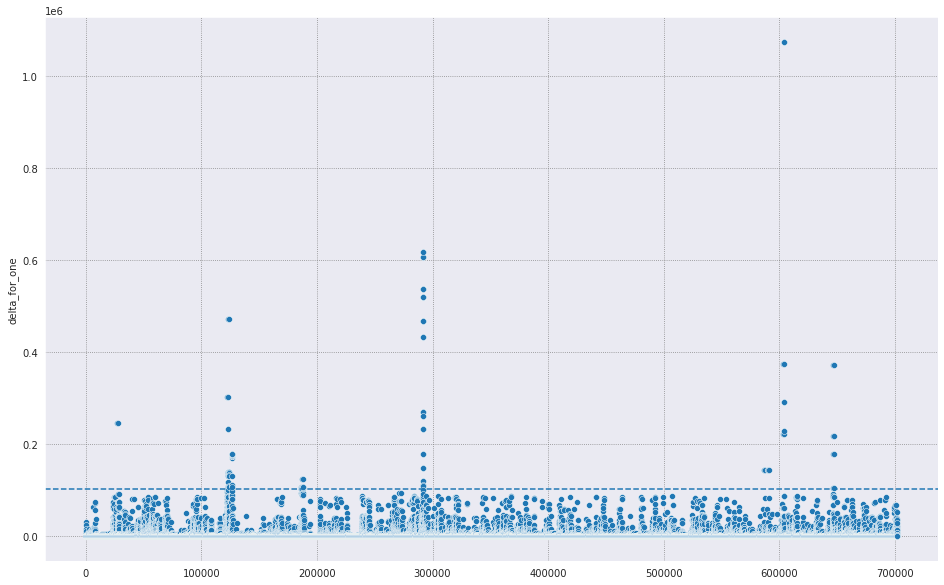

In [8]:
g = plt.figure(figsize=(16, 10))
sns.set_style("darkgrid", {"grid.color": ".5", "grid.linestyle": ":"})
sns.scatterplot(data=df['delta_for_one'],
                sizes = [20,8]
               )
ax = g.axes[0]
top_quantile = .9998
ax.axhline(df['delta_for_one'].quantile(top_quantile), ls='--')

In [9]:
# Фильтруем данные по выбранной границе
df = df[df['delta_for_one'] < df['delta_for_one'].quantile(top_quantile)]
df['delta_for_one_dt'].describe()

count                       701684
mean     0 days 00:08:35.858327965
std      0 days 00:48:27.451075930
min                0 days 00:00:02
25%                0 days 00:00:37
50%                0 days 00:01:15
75%                0 days 00:03:02
max                1 days 04:32:05
Name: delta_for_one_dt, dtype: object

## Плотность распределения

Благодаря устранению выбросов мы заметно снизили среднеквадратичное отклонение времени выполнения задания

Теперь необходимо построить кривую плотности.

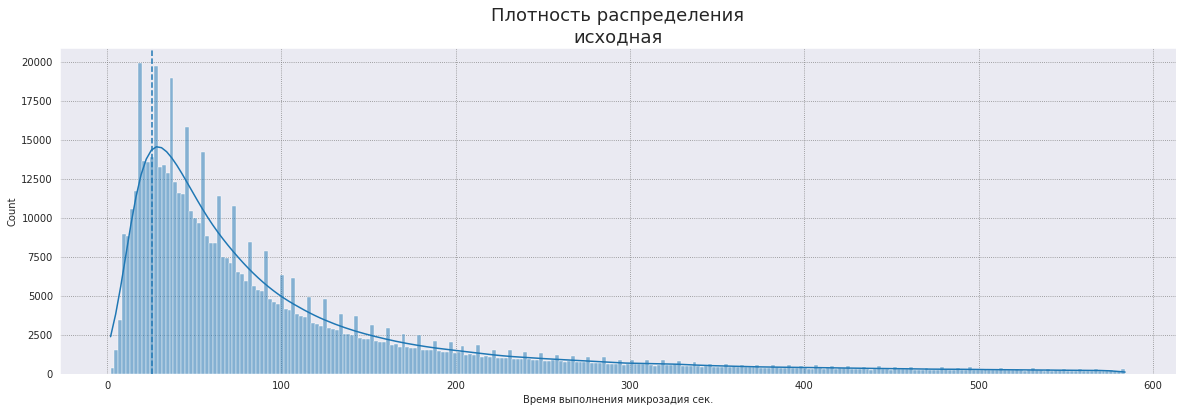

In [10]:

delt = df.loc[df['delta_for_one'] < df['delta_for_one'].quantile(top_quantile)
              , 'delta_for_one']
fig,ax = plt.subplots(figsize=(20,6))
sns.set_style("darkgrid", {"grid.color": ".5", "grid.linestyle": ":"})
sns.histplot(data=delt[(delt <= delt.quantile(.9))],kde = True, 
             ax=ax,
            )
# ax = g.axes[1]
max_count = df['delta_for_one'].value_counts().index[0]
plt.title("Плотность распределения\nисходная", fontsize=18)
plt.axvline(max_count, ls='--')
plt.xlabel('Время выполнения микрозадия сек.', fontsize=10)
plt.show()

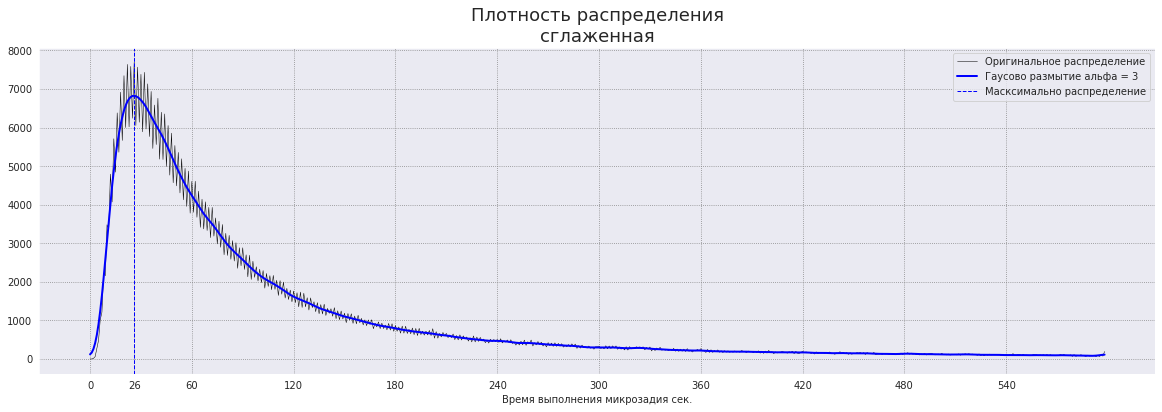

In [11]:
x_max = 600
alfa = 3
fig,ax = plt.subplots(figsize=(20,6))
x_ticks = list(range(0, x_max,60))
hist = np.histogram(delt, bins = range(x_max))[0]
hist_gaus = gaussian_filter1d(hist, alfa)
hist_gaus_max = np.argmax(hist_gaus)
plt.plot(hist, 'k', label='Оригинальное распределение', lw=0.5)
plt.plot(hist_gaus, 'b', lw=2, 
         label='Гаусово размытие альфа = ' + str(alfa))
plt.axvline(hist_gaus_max, color = 'b', ls='--', lw=1, 
           label = 'Масксимально распределение')
plt.title("Плотность распределения\nсглаженная", fontsize=18)
x_ticks.append(hist_gaus_max)
plt.xticks(x_ticks, x_ticks)
plt.xlabel('Время выполнения микрозадия сек.', fontsize=10)
plt.legend()

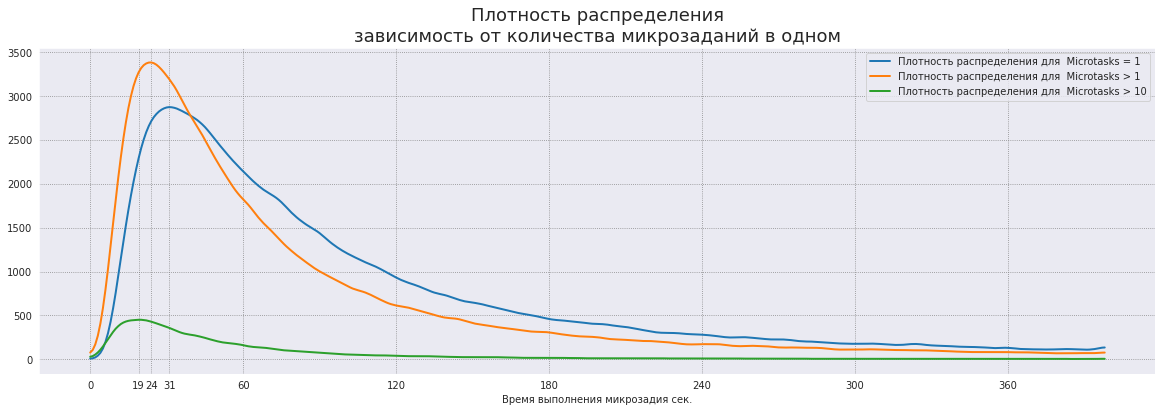

In [12]:
x_max = 400
alfa = 3
fig,ax = plt.subplots(figsize=(20,6))
x_ticks = list(range(0, x_max,60))
hist_1 = gaussian_filter1d(np.histogram(delt[df['Microtasks'] == 1], bins = range(x_max))[0], alfa)
hist_1_10 = gaussian_filter1d(np.histogram(delt[(df['Microtasks'] > 1) \
                                                &(df['Microtasks'] < 10)], bins = range(x_max))[0], alfa)
hist_10_ = gaussian_filter1d(np.histogram(delt[df['Microtasks'] > 10], bins = range(x_max))[0], alfa)

plt.plot(hist_1, lw=2, 
         label='Плотность распределения для  Microtasks = ' + str(1))
x_ticks.append(np.argmax(hist_1))
plt.plot(hist_1_10, lw=2, 
         label='Плотность распределения для  Microtasks > ' + str(1))
x_ticks.append(np.argmax(hist_1_10))
plt.plot(hist_10_, lw=2, 
         label='Плотность распределения для  Microtasks > ' + str(10))
x_ticks.append(np.argmax(hist_10_))
plt.title("Плотность распределения\nзависимость от количества микрозаданий в одном", fontsize=18)
plt.xlabel('Время выполнения микрозадия сек.', fontsize=10)
plt.xticks(x_ticks, x_ticks)
plt.legend()

In [13]:
# Процент заданий в которых количество микрозаданий > 1
(df_in['Microtasks'] > 1).value_counts() / df_in.shape[0] * 100

True     50.183592
False    49.816408
Name: Microtasks, dtype: float64

Из графика видно, что чем больше микрозаданий в одном, тем меньше тратится времени на выполнение одного задания.

Но так же мы видим, что примерно половина заданий выполняются по одному и справедливо ориентироваться на данные, где 'Microtasks' == 1

## Ответ

Из графика явно видно, что самая высокая плотность распределения находится в точке соответствующей времени выполнения задания 26 секунд. 

Для удобства расчетов мы округлим эту цифру в большую сторону с шагом 5 секунд. 

In [14]:
round_step = 5 
fair_delta = round_step * math.ceil(np.argmax(hist_1)/round_step)
print('Нормальное время выполнения задания:', str(round(fair_delta)), 'секунд')
print('Справедливая оплата за выполнение одного микрозадания: ', round(fair_delta / 30, 1), '* N')

Нормальное время выполнения задания: 35 секунд
Справедливая оплата за выполнение одного микрозадания:  1.2 * N


## Проверка

Смотрим какой процент заданий выполненн в заданый интервал

In [15]:
df_chek = data_prep(df_in)
print(str(round(
    df_chek[df_chek['delta_for_one'] <= fair_delta].shape[0] \
    / df_chek.shape[0] \
    * 100)) + '%' + ' заданий пользователи успели завершить в течении ' + str(round(fair_delta)), 'секунд')

24% заданий пользователи успели завершить в течении 35 секунд
